# Phase 3: Hand Keypoint Extraction with MediaPipe

## Why Extract Keypoints Instead of Raw Images?

1. **Dimensionality Reduction**: Raw video frames (640×480×3) → Hand keypoints (21 landmarks × 3 coordinates)
2. **Invariance**: Keypoints are robust to changes in:
   - Background (mudra shape is independent of background)
   - Lighting (only hand structure matters)
   - Camera angle (normalized keypoint coordinates)
3. **Temporal Focus**: LSTM learns from hand movement, not irrelevant image features
4. **Computational Efficiency**: Process 63 features per frame vs 921,600 pixel values

## What We'll Do

1. Initialize MediaPipe Hands (21 landmarks per hand)
2. Extract keypoints from all video frames
3. Handle missing detections with zero-padding
4. Visualize keypoints overlaid on frames
5. Save keypoints as NumPy arrays (.npy)

In [26]:
# Setup and imports
import sys
sys.path.insert(0, '/Users/vidanadheera/Documents/SEM - 6/CV/Mudra_recognition_new/src')

import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from video_utils import load_video, get_video_metadata
from hand_keypoints import HandKeypointExtractor

# Set base paths
BASE_DIR = Path('/Users/vidanadheera/Documents/SEM - 6/CV/Mudra_recognition_new')
DATA_DIR = BASE_DIR / 'data'
TRAIN_DIR = DATA_DIR / 'train_isolated'
TEST_DIR = DATA_DIR / 'test_continuous'
KEYPOINTS_DIR = BASE_DIR / 'keypoints'

KEYPOINTS_DIR.mkdir(parents=True, exist_ok=True)

print("=" * 60)
print("HAND KEYPOINT EXTRACTION")
print("=" * 60 + "\n")
print(f"Keypoints will be saved to: {KEYPOINTS_DIR}\n")

HAND KEYPOINT EXTRACTION

Keypoints will be saved to: /Users/vidanadheera/Documents/SEM - 6/CV/Mudra_recognition_new/keypoints



## Section 1: Initialize MediaPipe Hands Extractor

MediaPipe Hands extracts 21 landmarks per hand (single hand mode):
- **Wrist (0)**: Base of hand
- **Thumb (1-4)**: Tip to base
- **Index (5-8)**: Tip to base
- **Middle (9-12)**: Tip to base
- **Ring (13-16)**: Tip to base
- **Pinky (17-20)**: Tip to base

Each landmark has (x, y, z) coordinates (normalized 0-1).

In [27]:
# Load frames from all training videos
# ALWAYS reload to pick up any updated videos in the data folder

print("Loading training videos...\n")
try:
    # Reimport necessary libraries
    import glob
    
    TARGET_HEIGHT = 512
    TARGET_WIDTH = 512
    
    # Find all videos using flexible glob patterns to handle spaces and various file names
    pataka_videos = sorted(glob.glob(str(TRAIN_DIR / 'Pataka/*.mp4')))
    tripataka_videos = sorted(glob.glob(str(TRAIN_DIR / 'Tripataka/*.mp4')))
    
    print(f"Found {len(pataka_videos)} Pataka videos:")
    for v in pataka_videos:
        print(f"  - {Path(v).name}")
    
    print(f"\nFound {len(tripataka_videos)} Tripataka videos:")
    for v in tripataka_videos:
        print(f"  - {Path(v).name}")
    
    if len(pataka_videos) == 0 or len(tripataka_videos) == 0:
        print("\n⚠️  WARNING: No videos found. Check data/train_isolated/ directory structure")
    
    # Helper function to resize frames
    def resize_frames_helper(frames, target_h=TARGET_HEIGHT, target_w=TARGET_WIDTH):
        resized = []
        for frame in frames:
            resized_frame = cv2.resize(frame, (target_w, target_h))
            resized.append(resized_frame)
        return np.array(resized)
    
    # Load and combine Pataka videos
    pataka_all_frames = []
    pataka_all_labels = []
    for video_path in pataka_videos:
        print(f"\n  Loading: {Path(video_path).name}")
        frames, fps, num_frames = load_video(video_path)
        print(f"    - Frames loaded: {num_frames}")
        frames_resized = resize_frames_helper(frames)
        pataka_all_frames.append(frames_resized)
        pataka_all_labels.append(np.zeros(num_frames, dtype=np.int32))
    
    if pataka_all_frames:
        pataka_frames = np.concatenate(pataka_all_frames, axis=0)
        pataka_labels = np.concatenate(pataka_all_labels, axis=0)
        print(f"\n✓ Loaded Pataka frames: {pataka_frames.shape}")
    else:
        print("\n❌ No Pataka frames loaded!")
        pataka_frames = np.array([])
        pataka_labels = np.array([])
    
    # Load and combine Tripataka videos
    tripataka_all_frames = []
    tripataka_all_labels = []
    for video_path in tripataka_videos:
        print(f"\n  Loading: {Path(video_path).name}")
        frames, fps, num_frames = load_video(video_path)
        print(f"    - Frames loaded: {num_frames}")
        frames_resized = resize_frames_helper(frames)
        tripataka_all_frames.append(frames_resized)
        tripataka_all_labels.append(np.ones(num_frames, dtype=np.int32))
    
    if tripataka_all_frames:
        tripataka_frames = np.concatenate(tripataka_all_frames, axis=0)
        tripataka_labels = np.concatenate(tripataka_all_labels, axis=0)
        print(f"\n✓ Loaded Tripataka frames: {tripataka_frames.shape}")
    else:
        print("\n❌ No Tripataka frames loaded!")
        tripataka_frames = np.array([])
        tripataka_labels = np.array([])
    
except Exception as e:
    print(f"Error loading frames: {e}")
    raise


Loading training videos...

Found 2 Pataka videos:
  - pataka .mp4
  - pataka_2.mp4

Found 2 Tripataka videos:
  - tripataka .mp4
  - tripataka_3.mp4

  Loading: pataka .mp4
Video: pataka .mp4
  Resolution: 2148x1076
  FPS: 60.0
  Total Frames: 378
  Extracted: 378 frames

    - Frames loaded: 378

  Loading: pataka_2.mp4
Video: pataka_2.mp4
  Resolution: 2148x1076
  FPS: 59.64542058190875
  Total Frames: 343
  Extracted: 312 frames

    - Frames loaded: 312

✓ Loaded Pataka frames: (690, 512, 512, 3)

  Loading: tripataka .mp4
Video: tripataka .mp4
  Resolution: 2148x1076
  FPS: 60.0
  Total Frames: 233
  Extracted: 233 frames

    - Frames loaded: 233

  Loading: tripataka_3.mp4
Video: tripataka_3.mp4
  Resolution: 2148x1076
  FPS: 60.0
  Total Frames: 481
  Extracted: 481 frames

    - Frames loaded: 481

✓ Loaded Tripataka frames: (714, 512, 512, 3)


In [23]:
# Initialize extractor
extractor = HandKeypointExtractor(
    static_image_mode=False,
    max_num_hands=1,  # CRITICAL: Single hand only
    min_detection_confidence=0.5
)

print("MediaPipe Hands initialized:")
print(f"  - Mode: Single hand detection (max_num_hands=1)")
print(f"  - Landmarks per hand: 21")
print(f"  - Coordinates per landmark: 3 (x, y, z)")

MediaPipe Hands initialized:
  - Mode: Single hand detection (max_num_hands=1)
  - Landmarks per hand: 21
  - Coordinates per landmark: 3 (x, y, z)


I0000 00:00:1768669764.591128   22304 gl_context.cc:369] GL version: 2.1 (2.1 ATI-7.1.6), renderer: AMD Radeon Pro 5300M OpenGL Engine


W0000 00:00:1768669764.624366   63603 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1768669764.648252   63603 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


## Section 2: Extract Keypoints from Training Videos

Process each training video to extract hand keypoints from all frames.

In [24]:
# Extract keypoints from combined Pataka frames (from Notebook 01)
print("=" * 60)
print("EXTRACTING HAND KEYPOINTS")
print("=" * 60 + "\n")

print("Processing Pataka video frames (combined from all videos)...")
print(f"Total frames to process: {len(pataka_frames)}")

print(f"\nExtracting keypoints from {len(pataka_frames)} frames...")
pataka_keypoints, pataka_conf, pataka_hand = extractor.extract_keypoints_batch(pataka_frames)

# Convert confidence to numpy array if it's a list
pataka_conf = np.array(pataka_conf) if isinstance(pataka_conf, list) else pataka_conf

print(f"Pataka keypoints shape: {pataka_keypoints.shape}")
print(f"  - Frames: {pataka_keypoints.shape[0]}")
print(f"  - Landmarks: {pataka_keypoints.shape[1]}")
print(f"  - Coordinates (x,y,z): {pataka_keypoints.shape[2]}")
valid_detections = np.sum(pataka_conf > 0)
print(f"  - Frames with hand detected: {valid_detections}/{len(pataka_frames)} ({100*valid_detections/len(pataka_frames):.1f}%)")
if valid_detections > 0:
    print(f"  - Detection confidence (mean): {np.mean(pataka_conf[pataka_conf > 0]):.3f}\n")
else:
    print(f"  - ⚠️  WARNING: No hands detected in Pataka frames!\n")

# Save keypoints
KEYPOINTS_DIR.mkdir(parents=True, exist_ok=True)
pataka_kp_path = KEYPOINTS_DIR / 'pataka_keypoints.npy'
extractor.save_keypoints(pataka_keypoints, pataka_kp_path)
print(f"✓ Pataka keypoints saved to: {pataka_kp_path}\n")

# Extract keypoints from combined Tripataka frames (from Notebook 01)
print("Processing Tripataka video frames (combined from all videos)...")
print(f"Total frames to process: {len(tripataka_frames)}")

print(f"\nExtracting keypoints from {len(tripataka_frames)} frames...")
tripataka_keypoints, tripataka_conf, tripataka_hand = extractor.extract_keypoints_batch(tripataka_frames)

# Convert confidence to numpy array if it's a list
tripataka_conf = np.array(tripataka_conf) if isinstance(tripataka_conf, list) else tripataka_conf

print(f"Tripataka keypoints shape: {tripataka_keypoints.shape}")
print(f"  - Frames: {tripataka_keypoints.shape[0]}")
print(f"  - Landmarks: {tripataka_keypoints.shape[1]}")
print(f"  - Coordinates (x,y,z): {tripataka_keypoints.shape[2]}")
valid_detections = np.sum(tripataka_conf > 0)
print(f"  - Frames with hand detected: {valid_detections}/{len(tripataka_frames)} ({100*valid_detections/len(tripataka_frames):.1f}%)")
if valid_detections > 0:
    print(f"  - Detection confidence (mean): {np.mean(tripataka_conf[tripataka_conf > 0]):.3f}\n")
else:
    print(f"  - ⚠️  WARNING: No hands detected in Tripataka frames!\n")

# Save keypoints
tripataka_kp_path = KEYPOINTS_DIR / 'tripataka_keypoints.npy'
extractor.save_keypoints(tripataka_keypoints, tripataka_kp_path)
print(f"✓ Tripataka keypoints saved to: {tripataka_kp_path}\n")

print("=" * 60)
print("KEYPOINT EXTRACTION COMPLETE")
print("=" * 60)


EXTRACTING HAND KEYPOINTS

Processing Pataka video frames (combined from all videos)...
Total frames to process: 575

Extracting keypoints from 575 frames...
Pataka keypoints shape: (575, 21, 3)
  - Frames: 575
  - Landmarks: 21
  - Coordinates (x,y,z): 3
  - Frames with hand detected: 542/575 (94.3%)
  - Detection confidence (mean): 0.941

Saved keypoints to /Users/vidanadheera/Documents/SEM - 6/CV/Mudra_recognition_new/keypoints/pataka_keypoints.npy
✓ Pataka keypoints saved to: /Users/vidanadheera/Documents/SEM - 6/CV/Mudra_recognition_new/keypoints/pataka_keypoints.npy

Processing Tripataka video frames (combined from all videos)...
Total frames to process: 791

Extracting keypoints from 791 frames...
Tripataka keypoints shape: (791, 21, 3)
  - Frames: 791
  - Landmarks: 21
  - Coordinates (x,y,z): 3
  - Frames with hand detected: 687/791 (86.9%)
  - Detection confidence (mean): 0.926

Saved keypoints to /Users/vidanadheera/Documents/SEM - 6/CV/Mudra_recognition_new/keypoints/tripat

## Section 3: Visualize Hand Landmarks

Display sample frames with hand landmarks overlaid to verify correctness of extraction.

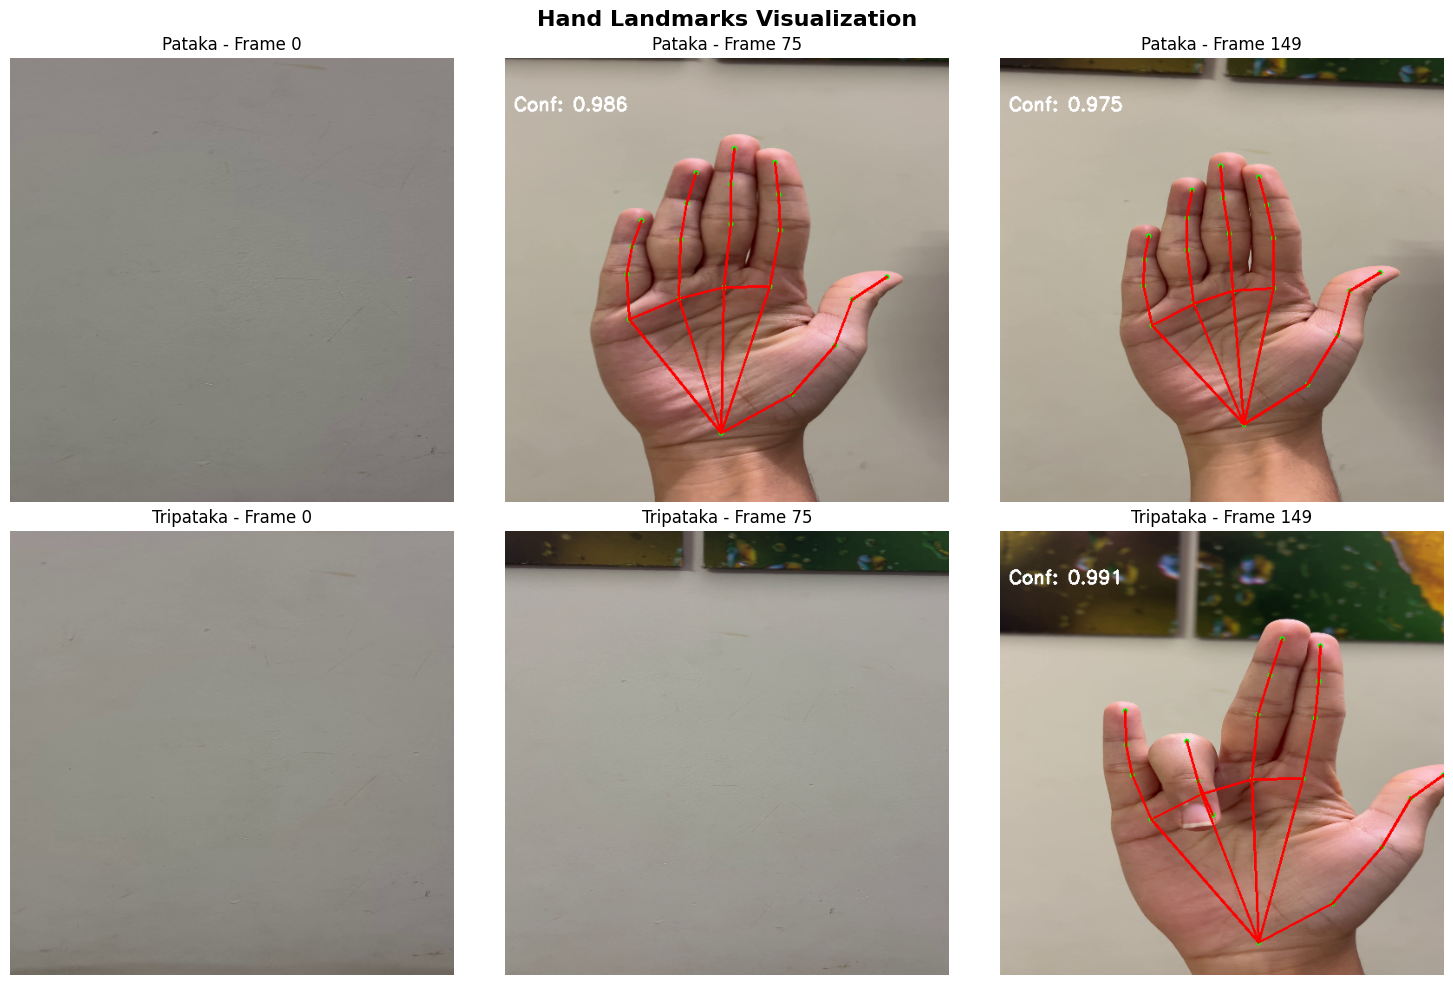

✓ Landmark visualization complete


In [25]:
# Visualize landmarks on frames
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Hand Landmarks Visualization', fontsize=16, fontweight='bold')

# Pataka visualization
frame_indices = [0, 75, 149]
for i, frame_idx in enumerate(frame_indices):
    frame_viz = extractor.draw_landmarks(
        pataka_frames[frame_idx], 
        pataka_keypoints[frame_idx],
        confidence=pataka_conf[frame_idx]
    )
    axes[0, i].imshow(frame_viz)
    axes[0, i].set_title(f'Pataka - Frame {frame_idx}')
    axes[0, i].axis('off')

# Tripataka visualization
for i, frame_idx in enumerate(frame_indices):
    frame_viz = extractor.draw_landmarks(
        tripataka_frames[frame_idx],
        tripataka_keypoints[frame_idx],
        confidence=tripataka_conf[frame_idx]
    )
    axes[1, i].imshow(frame_viz)
    axes[1, i].set_title(f'Tripataka - Frame {frame_idx}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

print("✓ Landmark visualization complete")

## Section 5: Analyze Detection Quality

Examine detection statistics to understand data quality.

In [21]:
# Analyze detection quality
print("=" * 60)
print("DETECTION QUALITY ANALYSIS")
print("=" * 60 + "\n")

print("Pataka:")
pataka_detected = np.sum([c > 0 for c in pataka_conf])
print(f"  - Frames with hand detected: {pataka_detected}/{len(pataka_conf)}")
print(f"  - Detection rate: {100 * pataka_detected / len(pataka_conf):.1f}%")
print(f"  - Mean confidence (detected frames): {np.mean([c for c in pataka_conf if c > 0]):.3f}")

print("\nTripataka:")
tripataka_detected = np.sum([c > 0 for c in tripataka_conf])
print(f"  - Frames with hand detected: {tripataka_detected}/{len(tripataka_conf)}")
print(f"  - Detection rate: {100 * tripataka_detected / len(tripataka_conf):.1f}%")
print(f"  - Mean confidence (detected frames): {np.mean([c for c in tripataka_conf if c > 0]):.3f}")

print(f"\n✓ Keypoint extraction complete!")
print(f"✓ All keypoints saved to {KEYPOINTS_DIR}\n")

DETECTION QUALITY ANALYSIS

Pataka:
  - Frames with hand detected: 542/575
  - Detection rate: 94.3%
  - Mean confidence (detected frames): 0.941

Tripataka:
  - Frames with hand detected: 687/791
  - Detection rate: 86.9%
  - Mean confidence (detected frames): 0.926

✓ Keypoint extraction complete!
✓ All keypoints saved to /Users/vidanadheera/Documents/SEM - 6/CV/Mudra_recognition_new/keypoints



## Summary: Phase 3 Complete ✓

**What we've accomplished:**
1. ✓ Initialized MediaPipe Hands (single hand, 21 landmarks)
2. ✓ Extracted 21 × 3 = 63 keypoint features per frame
3. ✓ Handled missing detections with zero-padding
4. ✓ Visualized landmarks on sample frames
5. ✓ Saved keypoints as NumPy arrays (.npy)

**Key insight:**
- Hand keypoints provide a compact, invariant representation of mudra shape
- Much more efficient than processing raw video frames
- Ready for temporal windowing and LSTM training

**Next steps (Phase 4):**
- Create overlapping temporal windows from keypoint sequences
- Align windows with mudra labels
- Prepare data for LSTM model training